<a href="https://colab.research.google.com/github/MWFK/TensorFlow-Certificate-study-materials/blob/main/11.%20Apply_DNN_to_Sarcasm_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Licensed under the Apache License, Version 2.0 (the "License");

In [1]:
# Run this to ensure TensorFlow 2.x is used
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

In [3]:
import json
import tensorflow as tf
print('tf version ',tf.version.VERSION)

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tf version  2.5.0


In [4]:
vocab_size = 10000
embedding_dim = 16
max_length = 100
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 20000

In [5]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json \
    -O /tmp/sarcasm.json

--2021-08-08 13:33:18--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.203.128, 142.250.98.128, 108.177.12.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.203.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5643545 (5.4M) [application/json]
Saving to: ‘/tmp/sarcasm.json’

/tmp/sarcasm.json   100%[===================>]   5.38M  --.-KB/s    in 0.04s   

2021-08-08 13:33:18 (143 MB/s) - ‘/tmp/sarcasm.json’ saved [5643545/5643545]



In [6]:
# Data Extraction
with open("/tmp/sarcasm.json", 'r') as f:
    datastore = json.load(f)

sentences = []
labels = []

for item in datastore:
    sentences.append(item['headline'])
    labels.append(item['is_sarcastic'])

In [7]:
training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

In [8]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [9]:
# Need this block to get it to work with TensorFlow 2.x
import numpy as np
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

In [10]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length), # Param = vocab_size * embedding
    tf.keras.layers.GlobalAveragePooling1D(), # Average Pooling is a pooling operation that calculates the average value for patches of a feature map, and uses it to create a downsampled (pooled) feature map. 
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 16)           160000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 24)                408       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 25        
Total params: 160,433
Trainable params: 160,433
Non-trainable params: 0
_________________________________________________________________


In [12]:
num_epochs = 30
history = model.fit(x=training_padded, y=training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=2)

Epoch 1/30
625/625 - 3s - loss: 0.6761 - accuracy: 0.5707 - val_loss: 0.6236 - val_accuracy: 0.6464
Epoch 2/30
625/625 - 2s - loss: 0.4522 - accuracy: 0.8177 - val_loss: 0.3917 - val_accuracy: 0.8332
Epoch 3/30
625/625 - 2s - loss: 0.3185 - accuracy: 0.8741 - val_loss: 0.3563 - val_accuracy: 0.8472
Epoch 4/30
625/625 - 2s - loss: 0.2676 - accuracy: 0.8953 - val_loss: 0.3444 - val_accuracy: 0.8530
Epoch 5/30
625/625 - 2s - loss: 0.2312 - accuracy: 0.9106 - val_loss: 0.3475 - val_accuracy: 0.8530
Epoch 6/30
625/625 - 2s - loss: 0.2039 - accuracy: 0.9227 - val_loss: 0.3576 - val_accuracy: 0.8508
Epoch 7/30
625/625 - 2s - loss: 0.1822 - accuracy: 0.9315 - val_loss: 0.3559 - val_accuracy: 0.8527
Epoch 8/30
625/625 - 2s - loss: 0.1638 - accuracy: 0.9377 - val_loss: 0.3660 - val_accuracy: 0.8523
Epoch 9/30
625/625 - 2s - loss: 0.1483 - accuracy: 0.9469 - val_loss: 0.3981 - val_accuracy: 0.8465
Epoch 10/30
625/625 - 2s - loss: 0.1340 - accuracy: 0.9518 - val_loss: 0.4127 - val_accuracy: 0.8463

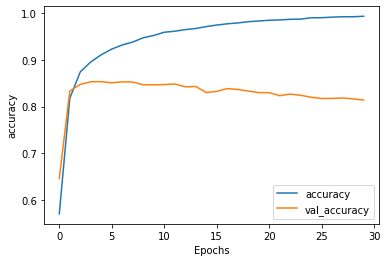

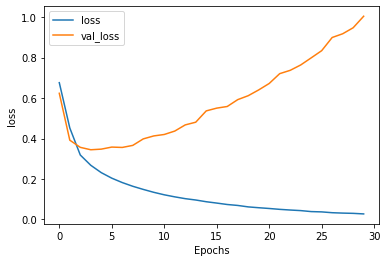

In [13]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

# Prediction

In [15]:
sentence = ["granny starting to fear spiders in the garden might be real", "game of thrones season finale showing this sunday night"]
sequences = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
print(model.predict(padded))

[[9.9295533e-01]
 [3.5595894e-04]]


# Reverse Modeling Explanation
##### word_index
##### reverse_word_index
##### word
##### weights
##### out_v
##### out_m

In [20]:
# print(word_index)
# 'coworker': 944,
#  'pick': 945,
#  'doctor': 946,
#  'harvey': 947,
#  'happens': 948,

In [21]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_sentence(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_sentence(training_padded[0]))
print(training_sentences[2])
print(labels[2])

former <OOV> store clerk sues over secret 'black <OOV> for minority shoppers ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ?
mom starting to fear son's web series closest thing she will have to grandchild
1


In [23]:
# print(reverse_word_index)
# 944: 'coworker',
# 945: 'pick',
# 946: 'doctor',
# 947: 'harvey',
# 948: 'happens',

In [ ]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

(10000, 16)


In [ ]:
import io

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
# In here we go through the reverse_word_index to store the words into the file out_m(meta)
# Then we store the weight of each word in the first layer into the file out_v(vecs)
for word_num in range(1, vocab_size):
  word = reverse_word_index[word_num]
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

In [ ]:
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>